Para este análisis se usó un conjunto de datos en el que se detallan los obsequios a funcionarios públicos registrados en el ámbito de la Oficina Anticorrupción.
Fuente: https://datos.gob.ar/dataset/justicia-registro-obsequios-funcionarios-publicos

In [21]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

In [10]:
data = pd.read_csv("./data/registro-obsequios-funcionarios-publicos-20201009.csv")
print('Cantidad de registros cargados: {}'.format(len(data)))
print(data.head())

Cantidad de registros cargados: 3928
                  expediente funcionario_nombre_completo  \
0  RL-2017-1920930-APN-OA#MJ               Leonardo Hugo   
1  RL-2017-1967319-APN-OA#MJ                       Laura   
2  RL-2017-1994454-APN-OA#MJ                        Mora   
3  RL-2017-2057755-APN-OA#MJ                   Christian   
4  RL-2017-2082409-APN-OA#MJ                       Laura   

  funcionario_apellido_completo  funcionario_cuil  \
0                      Limanski      2.032953e+10   
1                        Alonso      2.723121e+10   
2                        Kantor      2.728694e+10   
3                         Ramos      2.328460e+10   
4                        Alonso      2.723121e+10   

                    funcionario_jurisdiccion  \
0  Ministerio de Justicia y Derechos Humanos   
1  Ministerio de Justicia y Derechos Humanos   
2  Ministerio de Justicia y Derechos Humanos   
3                Ministerio de Modernización   
4  Ministerio de Justicia y Derechos Humano

In [11]:
# clean and unify data
data["obsequiador_cargo_representante"] = data["obsequiador_cargo_representante"].str.lower()
data["obsequio_descripcion"] = data["obsequio_descripcion"].str.lower()

In [12]:
data[["obsequio_caracter","obsequio_tipo"]].value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [13]:
gifts_by_value = data[["obsequio_valor_estimado","obsequio_tipo"]].groupby("obsequio_valor_estimado").count().sort_values("obsequio_tipo", ascending=False)
print("Valor aproximado de 4 módulos: $4.000")
print(gifts_by_value)

Valor aproximado de 4 módulos: $4.000
                                                    obsequio_tipo
obsequio_valor_estimado                                          
Inferior a 4 módulos.                                        3697
Superior a 4 módulos o imposibilidad de determi...            164
Inferior a 4 módulos pero con valor institucion...             67


In [14]:
gifts_by_role = data[["obsequiador_cargo_representante","obsequio_tipo"]].value_counts()
print(gifts_by_role)

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [15]:
gifts_by_role = data[["obsequiador_cargo_representante"]].value_counts()
print(gifts_by_role)

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [16]:
gifts_by_date = data[["obsequio_fecha_registro"]].value_counts()
print("Día con más regalos:")
print(gifts_by_date.head(5))
# print("Día con más regalos: {} {}".format(gifts_by_date.idxmax()[0], gifts_by_date.head(1).values))
# print(data.loc[(data["obsequio_fecha_registro"]=="2018-11-16") & (data["obsequio_tipo"]=="Otros"), ["obsequio_descripcion", "obsequio_valor_estimado"]].head(10))

AttributeError: 'DataFrame' object has no attribute 'value_counts'

Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)
https://www.argentina.gob.ar/justicia/igj/calculador-modulos
                                   obsequio_descripcion
obsequio_tipo                                          
Objetos en general                                   54
Otros                                                48
Obras de arte                                        22
Joyería y relojería                                  15
Artesanías (productos regionales)                    10
Alimentos                                             6
Libros                                                4
Indumentaria                                          3
Electrónicos                                          1
Mobiliario                                            1


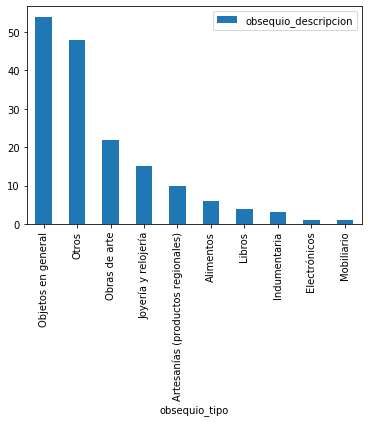

In [17]:
expensive_gifts = data[data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."]

print("Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)")
print("https://www.argentina.gob.ar/justicia/igj/calculador-modulos")
expensive_gifts_by_type = expensive_gifts[["obsequio_tipo", "obsequio_descripcion"]].groupby("obsequio_tipo").count().sort_values("obsequio_descripcion", ascending=False)

print(expensive_gifts_by_type)
expensive_gifts_by_type.plot(kind = 'bar')
plt.show()

In [18]:
print("Obsequios con un valor mayor a 4 módulos ($4.000)")
expensive_gifts["obsequio_descripcion"]

Obsequios con un valor mayor a 4 módulos ($4.000)


28      bolígrafo - montblanc - pix rollerball blue - ...
65                                              alfombras
104                  alfombra fbmi - modelo sultan mamluk
107      pañuelo hermes 90cm mythiques phoenix coloriages
142     "una (1) tetera de porcelana pintada-cuatro (4...
                              ...                        
3683                                        4 cajas de té
3702                                     bandeja de plata
3703                                        4 cajas de té
3704    caja de lata que contiene: una mascarilla de s...
3709    un mate de calabaza con detalle de alpaca y un...
Name: obsequio_descripcion, Length: 164, dtype: object

In [19]:
#TODO deberíamos limpiar de stopwords en español
# filtrar regalos entregados??
print(expensive_gifts.obsequio_descripcion.unique())

# Create a function to clean gift descriptions
def cleanTxt(text):
#  text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
#  text = re.sub('#', '', text) # Removing '#' hash tag
#  text = re.sub('RT[\s]+', '', text) # Removing RT
#  text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace(" -- ",'')
 text = text.strip()
 
 return text


# Clean gift descriptions
expensive_gifts.obsequio_descripcion = expensive_gifts.obsequio_descripcion.apply(cleanTxt)

print(expensive_gifts.obsequio_descripcion.unique())

 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación -- rosa metálica-'
 'inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación -- escudo metálico de la provincia de entre ríos'
 'inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación -- daga árabe en metal amarillo en su vaina con cinturón'
 'inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación -- rosa metálica con una chapa que reza "cristina - con aprecio de luis miguel"'
 'inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación -- escultura metálica en forma de rosa'
 'inscripción provisoria por comunicaci

In [20]:
# word cloud visualization
allWords = ' '.join([gifts for gifts in expensive_gifts["obsequio_descripcion"]])
# print(allWords)
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

NameError: name 'WordCloud' is not defined